# Model: WangchanBERTa

In [1]:
!pip freeze

absl-py==2.0.0
accelerate==0.24.1
annotated-types==0.6.0
arrow==1.3.0
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1698341106958/work
astunparse==1.6.3
attrs==23.1.0
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/backports.functools_lru_cache_1687772187254/work
boto3==1.28.81
botocore==1.31.81
bravado==11.0.3
bravado-core==6.1.0
cachetools==5.3.2
certifi==2023.7.22
charset-normalizer==3.3.1
click==8.1.7
comm @ file:///home/conda/feedstock_root/build_artifacts/comm_1691044910542/work
contourpy==1.1.1
cycler==0.12.1
debugpy @ file:///home/conda/feedstock_root/build_artifacts/debugpy_1695534290310/work
decorator @ file:///home/conda/feedstock_root/build_artifacts/decorator_1641555617451/work
emoji==2.8.0
exceptiongroup @ file:///home/conda/feedstock_root/build_artifacts/exceptiongroup_1692026125334/work
executing @ file:///home/conda/feedstock_root/build_artifacts/executing_1698579936712/work
filelock==3.12.4
flatbuffers==23.5.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import numpy as np
import math
import re
import torch
import json
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

/root/miniconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-08 23:13:44.469298: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 23:13:44.510454: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 23:13:44.510496: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 23:13:44.510532: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS w

# Raw Data

In [3]:
df = pd.read_csv('../data/tscc_v0.1-judgement.csv')
print(len(df))
df.head()

1207


,issueid,dekaid,year,category,issueno,lawids,fact,decision,isact,isexternalelements,isinternalelement,isintent,isneglect,iscause,isjustify,isexcuse,isguilty,isattempt,isattemptimpossible
0,1,1478/2528,2528,LB,1,"CC-288-00,CC-083-00,CC-063-00",จำเลยกับพวกร่วมกันใช้อาวุธปืนยิงผู้ตายถูกที่ด้...,จำเลยจึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,1,1,-1,1,0,0,1,0,-1
1,2,1548/2531,2531,LB,1,CC-288-00,จำเลยที่ 1 ซึ่งเคยมีเรื่องทะเลาะกับผู้ตายมาก่อ...,จำเลยที่ 1 จึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,1,1,-1,1,0,0,1,0,-1
2,3,1548/2531,2531,LB,2,"CC-290-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,1,1,1,1,-1,1,0,0,1,0,-1
3,4,1548/2531,2531,LB,3,"CC-288-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,0,-1,-1,-1,-1,-1,-1,-1,0,-1,-1
4,5,1697/2522,2522,LB,1,"CC-288-00,CC-083-00",โจทก์บรรยายฟ้องว่า จำเลยกับพวกที่ยังไม่ได้ตัวม...,จึงเป็นการกระทำโดยมีเจตนาฆ่าผู้ตาย แม้ข้อเท็จจ...,1,1,1,1,-1,1,0,0,1,0,-1


# Preprocess

## Filter non-relevant article ids

In [4]:
lawids_df = df['lawids']

lawids = []
for ids in lawids_df:
    lawids.extend(ids.split(','))
lawids_set = set(lawids)
print('# Article IDs (before filtering out): ', len(lawids_set))

''' remove any articles with id <= 106 '''
labels = list(filter(lambda x: int(x.split('-')[1][:3]) > 106, lawids_set))
print('# Article IDs (after filtering out): ', len(labels))


# # Select only OFFENCE AGAINST LIFE AND BODY (288 - 300)
# ''' remove any articles with id > 300'''
# labels = list(filter(lambda x: int(x.split('-')[1][:3]) <= 300, labels))
# print('# Article IDs (after filtering out (>300)): ', len(labels))
# '''remove any articles from the list: ['CC-289(3)-00', 'CC-298-00']'''
# lawid_filter_list = ['CC-289(3)-00', 'CC-298-00']
# labels = list(filter(lambda x: x not in lawid_filter_list, labels))
# print('# Article IDs (after filtering out (from list)): ', len(labels))

# Select only OFFENCE AGAINST LIBERTY AND REPUTATION (326 - 333)
# ''' remove any articles with id > 333 or < 326'''
# labels = list(filter(lambda x: 326 <= int(x.split('-')[1][:3]) <= 333, labels))
# print('# Article IDs (after filtering out (<326 or > 333)): ', len(labels))

'''remove articles that appear less than 5 times'''
drop_article_list = ['CC-390-00','CC-289(7)-00', 'CC-339-01', 'CC-342-00', 'CC-338-00', 'CC-335-01', 
                     'CC-335bis-00', 'CC-289(3)-00', 'CC-354-00', 'CC-298-00', 'CC-335bis-01']
labels = [x for x in labels if x not in drop_article_list]
print('# Article IDs (after dropping non frequent articles): ', len(labels))

labels

# Article IDs (before filtering out):  76
# Article IDs (after filtering out):  50
# Article IDs (after dropping non frequent articles):  39


['CC-291-00',
 'CC-288-00',
 'CC-334-00',
 'CC-326-02',
 'CC-341-00',
 'CC-336-00',
 'CC-335-02',
 'CC-328-02',
 'CC-300-00',
 'CC-326-00',
 'CC-339-00',
 'CC-296-00',
 'CC-336bis-00',
 'CC-393-00',
 'CC-331-00',
 'CC-326-01',
 'CC-358-00',
 'CC-340-00',
 'CC-330-00',
 'CC-328-01',
 'CC-297-00',
 'CC-343-00',
 'CC-328-00',
 'CC-340-01',
 'CC-339-02',
 'CC-337-00',
 'CC-289(6)-00',
 'CC-329-00',
 'CC-290-00',
 'CC-340ter-00',
 'CC-289(5)-00',
 'CC-391-00',
 'CC-360-00',
 'CC-352-00',
 'CC-335-00',
 'CC-393-01',
 'CC-295-00',
 'CC-289(4)-00',
 'CC-289(2)-00']

# Id2Label

In [5]:
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {str(label):idx for idx, label in enumerate(labels)}

## Filter \<discr>...\</discr> portion out of fact description

In [6]:
pattern = r'<discr>.*?</discr>'
df['filtered_fact'] = df.fact.apply(lambda x: re.sub(pattern, '', x)).copy()
df.head()

,issueid,dekaid,year,category,issueno,lawids,fact,decision,isact,isexternalelements,isinternalelement,isintent,isneglect,iscause,isjustify,isexcuse,isguilty,isattempt,isattemptimpossible,filtered_fact
0,1,1478/2528,2528,LB,1,"CC-288-00,CC-083-00,CC-063-00",จำเลยกับพวกร่วมกันใช้อาวุธปืนยิงผู้ตายถูกที่ด้...,จำเลยจึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,1,1,-1,1,0,0,1,0,-1,จำเลยกับพวกร่วมกันใช้อาวุธปืนยิงผู้ตายถูกที่ด้...
1,2,1548/2531,2531,LB,1,CC-288-00,จำเลยที่ 1 ซึ่งเคยมีเรื่องทะเลาะกับผู้ตายมาก่อ...,จำเลยที่ 1 จึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,1,1,-1,1,0,0,1,0,-1,จำเลยที่ 1 ซึ่งเคยมีเรื่องทะเลาะกับผู้ตายมาก่อ...
2,3,1548/2531,2531,LB,2,"CC-290-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,1,1,1,1,-1,1,0,0,1,0,-1,ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...
3,4,1548/2531,2531,LB,3,"CC-288-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,0,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...
4,5,1697/2522,2522,LB,1,"CC-288-00,CC-083-00",โจทก์บรรยายฟ้องว่า จำเลยกับพวกที่ยังไม่ได้ตัวม...,จึงเป็นการกระทำโดยมีเจตนาฆ่าผู้ตาย แม้ข้อเท็จจ...,1,1,1,1,-1,1,0,0,1,0,-1,โจทก์บรรยายฟ้องว่า จำเลยกับพวกที่ยังไม่ได้ตัวม...


## One-hot Encoding

In [7]:
def label_encoding(case_lawids, lawid):
    if lawid in case_lawids:
        return 1
    else:
        return 0



for label in labels:
    # df2[label] = df2.lawids.apply(lambda x: label_encoding(x, label))
    df[label] = df.lawids.apply(lambda x: label_encoding(x, label))
   
df = df[~(df[labels] == 0).all(axis=1)]
df = df.reset_index(drop=True)
df.head()

,issueid,dekaid,year,category,issueno,lawids,fact,decision,isact,isexternalelements,...,CC-340ter-00,CC-289(5)-00,CC-391-00,CC-360-00,CC-352-00,CC-335-00,CC-393-01,CC-295-00,CC-289(4)-00,CC-289(2)-00
0,1,1478/2528,2528,LB,1,"CC-288-00,CC-083-00,CC-063-00",จำเลยกับพวกร่วมกันใช้อาวุธปืนยิงผู้ตายถูกที่ด้...,จำเลยจึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,1548/2531,2531,LB,1,CC-288-00,จำเลยที่ 1 ซึ่งเคยมีเรื่องทะเลาะกับผู้ตายมาก่อ...,จำเลยที่ 1 จึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,...,0,0,0,0,0,0,0,0,0,0
2,3,1548/2531,2531,LB,2,"CC-290-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,1,1,...,0,0,0,0,0,0,0,0,0,0
3,4,1548/2531,2531,LB,3,"CC-288-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,0,-1,...,0,0,0,0,0,0,0,0,0,0
4,5,1697/2522,2522,LB,1,"CC-288-00,CC-083-00",โจทก์บรรยายฟ้องว่า จำเลยกับพวกที่ยังไม่ได้ตัวม...,จึงเป็นการกระทำโดยมีเจตนาฆ่าผู้ตาย แม้ข้อเท็จจ...,1,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
cols = df.columns
label_cols = list(cols[20:])
num_labels = len(label_cols)
print('num_labels: ', num_labels)
print('Label columns: ', label_cols)

num_labels:  39
Label columns:  ['CC-291-00', 'CC-288-00', 'CC-334-00', 'CC-326-02', 'CC-341-00', 'CC-336-00', 'CC-335-02', 'CC-328-02', 'CC-300-00', 'CC-326-00', 'CC-339-00', 'CC-296-00', 'CC-336bis-00', 'CC-393-00', 'CC-331-00', 'CC-326-01', 'CC-358-00', 'CC-340-00', 'CC-330-00', 'CC-328-01', 'CC-297-00', 'CC-343-00', 'CC-328-00', 'CC-340-01', 'CC-339-02', 'CC-337-00', 'CC-289(6)-00', 'CC-329-00', 'CC-290-00', 'CC-340ter-00', 'CC-289(5)-00', 'CC-391-00', 'CC-360-00', 'CC-352-00', 'CC-335-00', 'CC-393-01', 'CC-295-00', 'CC-289(4)-00', 'CC-289(2)-00']


## Stats

In [9]:
print('Count of 1 per label: \n', df[label_cols].sum(), '\n')
print('Count of 0 per label: \n', df[label_cols].eq(0).sum())


Count of 1 per label: 
 CC-291-00        18
CC-288-00       221
CC-334-00        90
CC-326-02        26
CC-341-00       183
CC-336-00         7
CC-335-02        46
CC-328-02        40
CC-300-00        13
CC-326-00        61
CC-339-00         6
CC-296-00         5
CC-336bis-00     11
CC-393-00        20
CC-331-00        11
CC-326-01        57
CC-358-00         8
CC-340-00         5
CC-330-00        14
CC-328-01        51
CC-297-00        26
CC-343-00         6
CC-328-00        17
CC-340-01         9
CC-339-02        15
CC-337-00         8
CC-289(6)-00      6
CC-329-00       108
CC-290-00        20
CC-340ter-00     10
CC-289(5)-00     10
CC-391-00        11
CC-360-00         7
CC-352-00        61
CC-335-00         8
CC-393-01        27
CC-295-00        44
CC-289(4)-00     48
CC-289(2)-00     13
dtype: int64 

Count of 0 per label: 
 CC-291-00       1166
CC-288-00        963
CC-334-00       1094
CC-326-02       1158
CC-341-00       1001
CC-336-00       1177
CC-335-02       1138
CC-328-02 

In [10]:
np_labels = list(map(tuple, df[label_cols].sum().items()))
np_labels.sort(key=lambda x: x[1], reverse=True)
np_labels

[('CC-288-00', 221),
 ('CC-341-00', 183),
 ('CC-329-00', 108),
 ('CC-334-00', 90),
 ('CC-326-00', 61),
 ('CC-352-00', 61),
 ('CC-326-01', 57),
 ('CC-328-01', 51),
 ('CC-289(4)-00', 48),
 ('CC-335-02', 46),
 ('CC-295-00', 44),
 ('CC-328-02', 40),
 ('CC-393-01', 27),
 ('CC-326-02', 26),
 ('CC-297-00', 26),
 ('CC-393-00', 20),
 ('CC-290-00', 20),
 ('CC-291-00', 18),
 ('CC-328-00', 17),
 ('CC-339-02', 15),
 ('CC-330-00', 14),
 ('CC-300-00', 13),
 ('CC-289(2)-00', 13),
 ('CC-336bis-00', 11),
 ('CC-331-00', 11),
 ('CC-391-00', 11),
 ('CC-340ter-00', 10),
 ('CC-289(5)-00', 10),
 ('CC-340-01', 9),
 ('CC-358-00', 8),
 ('CC-337-00', 8),
 ('CC-335-00', 8),
 ('CC-336-00', 7),
 ('CC-360-00', 7),
 ('CC-339-00', 6),
 ('CC-343-00', 6),
 ('CC-289(6)-00', 6),
 ('CC-296-00', 5),
 ('CC-340-00', 5)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


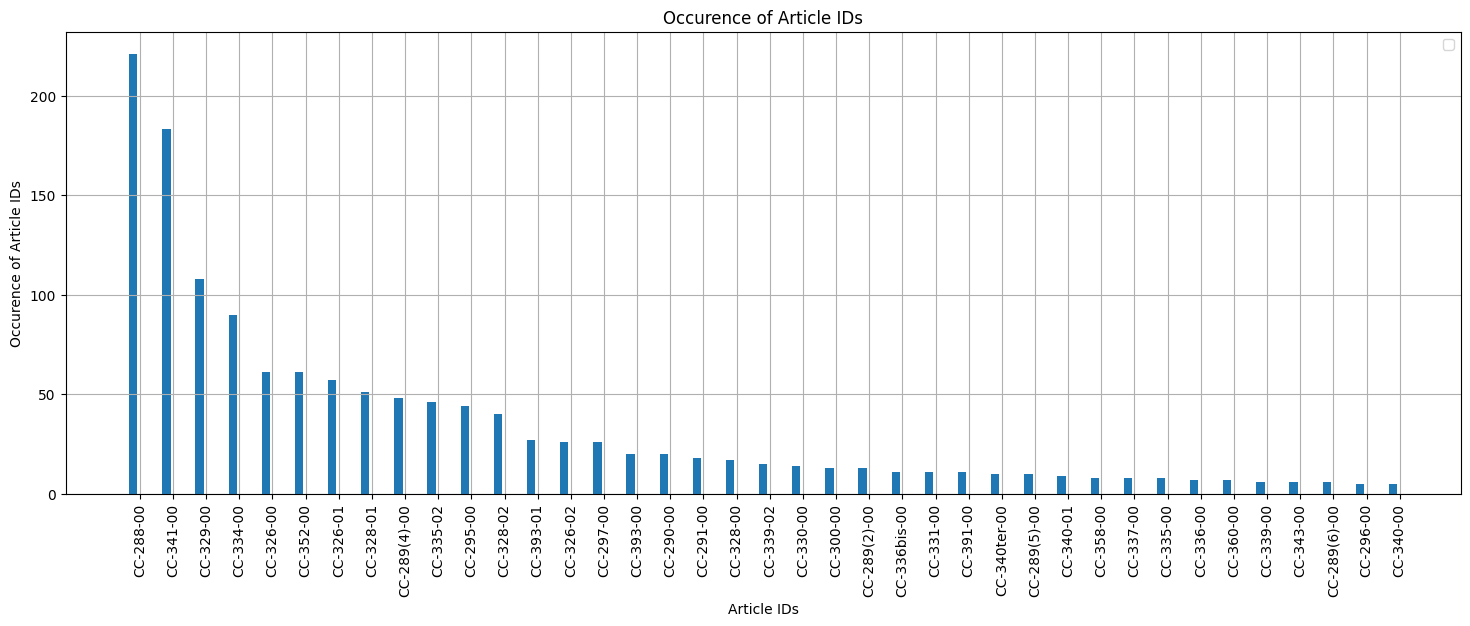

In [11]:
laws, counts = zip(*np_labels)

x = range(len(laws))
x2 = [i + 0.4 for i in x if laws[i] in laws]
width = 0.25

plt.figure(figsize=(18,6))
plt.bar(x, counts, width=width)

x_ticks_labels = [str(lawid) for lawid in laws]
plt.xticks([x + 0.2 for x in x], x_ticks_labels, rotation='vertical')
plt.ylabel('Occurence of Article IDs')
plt.xlabel('Article IDs')
plt.title('Occurence of Article IDs')
plt.grid()
plt.legend()
plt.show()

## Multi one-hot labels

In [12]:
df['one_hot_labels'] = list(df[label_cols].values)
df.head()

,issueid,dekaid,year,category,issueno,lawids,fact,decision,isact,isexternalelements,...,CC-289(5)-00,CC-391-00,CC-360-00,CC-352-00,CC-335-00,CC-393-01,CC-295-00,CC-289(4)-00,CC-289(2)-00,one_hot_labels
0,1,1478/2528,2528,LB,1,"CC-288-00,CC-083-00,CC-063-00",จำเลยกับพวกร่วมกันใช้อาวุธปืนยิงผู้ตายถูกที่ด้...,จำเลยจึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,1548/2531,2531,LB,1,CC-288-00,จำเลยที่ 1 ซึ่งเคยมีเรื่องทะเลาะกับผู้ตายมาก่อ...,จำเลยที่ 1 จึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,1548/2531,2531,LB,2,"CC-290-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,1,1,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,1548/2531,2531,LB,3,"CC-288-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,0,-1,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,1697/2522,2522,LB,1,"CC-288-00,CC-083-00",โจทก์บรรยายฟ้องว่า จำเลยกับพวกที่ยังไม่ได้ตัวม...,จึงเป็นการกระทำโดยมีเจตนาฆ่าผู้ตาย แม้ข้อเท็จจ...,1,1,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
mult_labels = list(df.one_hot_labels.values)
facts = list(df.filtered_fact.values)
print(len(mult_labels))
print(len(facts))


1184
1184


# Create Dataset

## Tokenizer from Model 

In [14]:
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
# model_name = "xlm-roberta-base"

In [15]:
# Counter([len(tokenizer.tokenize(sent)) for sent in facts])

In [16]:
!pip install transformers
!pip install -q emoji pythainlp==2.2.4 sefr_cut tinydb seqeval sentencepiece pydantic jsonlines
!pip install --no-deps thai2transformers==0.1.2

In [17]:
!pip freeze | grep sentence

sentencepiece==0.1.99


In [18]:
max_length = 416
tokenizer = AutoTokenizer.from_pretrained(
                model_name,
                revision='main',
                model_max_length=max_length,)

encodings = tokenizer(facts, max_length=max_length, padding=True, truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [19]:
!pip freeze | grep sentence

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


sentencepiece==0.1.99


In [20]:
type(encodings)

transformers.tokenization_utils_base.BatchEncoding

In [21]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

## Stratifying

In [22]:
label_counts = df.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [687, 682, 386, 373, 300, 216, 210, 208]


In [23]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [mult_labels.pop(i) for i in one_freq_idxs]

## Train, Valid Split

In [24]:
# Use train_test_split to split our data into train and validation sets

train_inputs, valid_inputs, train_labels, \
    valid_labels, train_masks, valid_masks = train_test_split(input_ids, mult_labels, attention_masks,
                                                            random_state=111, test_size=0.10, stratify=mult_labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.FloatTensor(train_labels)
train_masks = torch.tensor(train_masks)

valid_inputs = torch.tensor(valid_inputs)
valid_labels = torch.FloatTensor(valid_labels)
valid_masks = torch.tensor(valid_masks)

/tmp/ipykernel_190766/3558801885.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  train_labels = torch.FloatTensor(train_labels)


## Dataset

## Change to dictionary for Trainer class

In [25]:
class TSCCDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, masks, labels):
        self.inputs = inputs
        self.masks = masks
        self.labels = labels

    def __getitem__(self, idx):
        item = {'input_ids': self.inputs[idx], 'attention_mask': self.masks[idx], 'labels': self.labels[idx]}
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TSCCDataset(train_inputs, train_masks, train_labels)
valid_dataset = TSCCDataset(valid_inputs, valid_masks, valid_labels)

# Load Model & Set Params

In [26]:
#revision = "finetuned@wisesight_sentiment"
revision = None
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels, revision=revision, problem_type='multi_label_classification'
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
'''Trying forward pass'''
outputs = model(input_ids=train_dataset[0]['input_ids'].unsqueeze(0), 
    labels=train_dataset[0]['labels'].unsqueeze(0),
    attention_mask=train_dataset[0]['attention_mask'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.7213, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 9.7679e-02,  4.4856e-02,  5.0295e-01,  4.6587e-01, -2.7440e-04,
          1.6672e-01, -4.1648e-02, -5.0141e-02, -3.3115e-01,  2.0704e-01,
         -3.1914e-01,  3.3404e-01,  2.6885e-01,  4.1150e-02,  3.2977e-02,
          3.0143e-01,  5.3806e-03,  2.8228e-01,  6.5218e-02,  2.4088e-01,
         -3.1905e-01, -8.4271e-03, -8.3819e-02, -1.2460e-01, -3.1813e-01,
          1.7376e-01, -1.4586e-01,  6.6033e-02,  6.6131e-03,  6.6486e-02,
         -2.4763e-01, -1.1249e-01,  2.5465e-01, -1.8085e-01,  2.1518e-01,
          4.7952e-01, -5.0439e-02,  2.1934e-01, -9.0609e-02]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [28]:
outputs = model(input_ids=train_dataset[0]['input_ids'].unsqueeze(0), 
    labels=train_dataset[0]['labels'].unsqueeze(0),
    attention_mask=train_dataset[0]['attention_mask'].unsqueeze(0),
    output_hidden_states = True)
outputs.hidden_states[-1].mean(1).shape

torch.Size([1, 768])

# Train

In [29]:
!pip install neptune
!pip install transformers[torch]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, multilabel_confusion_matrix, classification_report
from transformers import EvalPrediction
import torch

from transformers.integrations import NeptuneCallback
import neptune

In [31]:
import os
from getpass import getpass
os.environ["NEPTUNE_API_TOKEN"] = getpass("Enter API token: ")
os.environ["NEPTUNE_PROJECT"] = "kanathip137/wangchanberta-finetuned-relevant-article"

In [32]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, y_labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = y_labels
    
    # y_pred = y_pred.flatten()
    # y_true = y_true.flatten()
    # print('y_true', y_true.shape)
    # print('y_pred', y_pred.shape)
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred, normalize=True)
    confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=False, target_names=labels)
    report_sample_wise = classification_report(y_true.T, y_pred.T, output_dict=False, target_names=labels)
    
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'confusion_matrix': confusion_matrix.tolist(),
               'report': report}
    return metrics

def compute_metrics(p: EvalPrediction):
    # print(p.label_ids)
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        y_labels=p.label_ids)
    return result

In [33]:
batch_size = 32
metric_name = 'f1'

In [34]:
training_args = TrainingArguments(
    output_dir='./wangchanberta-finetuned-relevant-article-pred-all',          # output directory
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=batch_size,  # batch size per device during training
    per_device_eval_batch_size=batch_size,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./wangchanberta-finetuned-relevant-article-pred-all-logs',            # directory for storing logs
    logging_steps=1,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #evaluation_strategy='epoch'
    report_to="neptune",
)

In [35]:
# training_args = TrainingArguments(
#     f"wangchanberta-finetuned-relevant-article-pred-liberty",
#     evaluation_strategy = "epoch",
#     save_strategy = "epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     num_train_epochs=5,
#     weight_decay=0.01,
#     load_best_model_at_end=True,
#     metric_for_best_model=metric_name,
#     #push_to_hub=True,
#     logging_dir='/wangchanberta_finetuned_relevant_article_pred_liberty_logs',
#     logging_steps=1,
# )

In [36]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,        # evaluation dataset
    compute_metrics=compute_metrics,
)

In [37]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [38]:
trainer.train()

/root/miniconda3/envs/myenv/lib/python3.10/site-packages/transformers/integrations/integration_utils.py:1235: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  self._run = init_run(**self._init_run_kwargs, **additional_neptune_kwargs)


https://app.neptune.ai/kanathip137/wangchanberta-finetuned-relevant-article/e/WAN-18


/root/miniconda3/envs/myenv/lib/python3.10/site-packages/neptune/internal/utils/git.py:71: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


OutOfMemoryError: CUDA out of memory. Tried to allocate 254.00 MiB. GPU 0 has a total capacty of 39.39 GiB of which 161.38 MiB is free. Process 376947 has 2.77 GiB memory in use. Process 3836752 has 32.26 GiB memory in use. Process 3852043 has 3.88 GiB memory in use. Of the allocated memory 3.32 GiB is allocated by PyTorch, and 75.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
result_eval = trainer.evaluate()
result_eval

/root/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


https://app.neptune.ai/kanathip137/wangchanberta-finetuned-relevant-article/e/WAN-17


/root/miniconda3/envs/myenv/lib/python3.10/site-packages/neptune/internal/utils/git.py:71: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


{'eval_loss': 0.08185388892889023,
 'eval_f1': 0.4148936170212766,
 'eval_roc_auc': 0.6478756708407871,
 'eval_accuracy': 0.2711864406779661,
 'eval_confusion_matrix': [[[117, 0], [1, 0]],
  [[117, 0], [1, 0]],
  [[115, 0], [3, 0]],
  [[113, 0], [5, 0]],
  [[118, 0], [0, 0]],
  [[117, 0], [1, 0]],
  [[101, 7], [3, 7]],
  [[117, 0], [1, 0]],
  [[116, 0], [2, 0]],
  [[116, 0], [2, 0]],
  [[115, 0], [3, 0]],
  [[117, 0], [1, 0]],
  [[116, 0], [2, 0]],
  [[117, 0], [1, 0]],
  [[112, 0], [6, 0]],
  [[113, 0], [5, 0]],
  [[118, 0], [0, 0]],
  [[88, 8], [7, 15]],
  [[117, 0], [1, 0]],
  [[117, 0], [1, 0]],
  [[116, 0], [2, 0]],
  [[117, 0], [1, 0]],
  [[109, 0], [9, 0]],
  [[114, 0], [4, 0]],
  [[114, 0], [4, 0]],
  [[117, 0], [1, 0]],
  [[113, 0], [5, 0]],
  [[117, 0], [1, 0]],
  [[117, 0], [1, 0]],
  [[118, 0], [0, 0]],
  [[117, 0], [1, 0]],
  [[116, 0], [2, 0]],
  [[114, 0], [4, 0]],
  [[118, 0], [0, 0]],
  [[113, 0], [5, 0]],
  [[96, 4], [1, 17]],
  [[118, 0], [0, 0]],
  [[115, 0], [3, 0]

In [ ]:
valid_dataset

In [ ]:
# [[TN, FP], [FN, TP]]
result_eval['eval_confusion_matrix']

[[[117, 0], [1, 0]],
 [[117, 0], [1, 0]],
 [[115, 0], [3, 0]],
 [[113, 0], [5, 0]],
 [[118, 0], [0, 0]],
 [[117, 0], [1, 0]],
 [[101, 7], [3, 7]],
 [[117, 0], [1, 0]],
 [[116, 0], [2, 0]],
 [[116, 0], [2, 0]],
 [[115, 0], [3, 0]],
 [[117, 0], [1, 0]],
 [[116, 0], [2, 0]],
 [[117, 0], [1, 0]],
 [[112, 0], [6, 0]],
 [[113, 0], [5, 0]],
 [[118, 0], [0, 0]],
 [[88, 8], [7, 15]],
 [[117, 0], [1, 0]],
 [[117, 0], [1, 0]],
 [[116, 0], [2, 0]],
 [[117, 0], [1, 0]],
 [[109, 0], [9, 0]],
 [[114, 0], [4, 0]],
 [[114, 0], [4, 0]],
 [[117, 0], [1, 0]],
 [[113, 0], [5, 0]],
 [[117, 0], [1, 0]],
 [[117, 0], [1, 0]],
 [[118, 0], [0, 0]],
 [[117, 0], [1, 0]],
 [[116, 0], [2, 0]],
 [[114, 0], [4, 0]],
 [[118, 0], [0, 0]],
 [[113, 0], [5, 0]],
 [[96, 4], [1, 17]],
 [[118, 0], [0, 0]],
 [[115, 0], [3, 0]],
 [[117, 0], [1, 0]]]

In [ ]:
print(result_eval['eval_report'])

              precision    recall  f1-score   support

   CC-360-00       0.00      0.00      0.00         1
CC-289(6)-00       0.00      0.00      0.00         1
   CC-393-01       0.00      0.00      0.00         3
   CC-326-00       0.00      0.00      0.00         5
   CC-340-00       0.00      0.00      0.00         0
CC-289(2)-00       0.00      0.00      0.00         1
   CC-329-00       0.50      0.70      0.58        10
   CC-343-00       0.00      0.00      0.00         1
   CC-393-00       0.00      0.00      0.00         2
   CC-290-00       0.00      0.00      0.00         2
   CC-297-00       0.00      0.00      0.00         3
   CC-335-00       0.00      0.00      0.00         1
   CC-291-00       0.00      0.00      0.00         2
   CC-300-00       0.00      0.00      0.00         1
   CC-352-00       0.00      0.00      0.00         6
CC-289(4)-00       0.00      0.00      0.00         5
   CC-330-00       0.00      0.00      0.00         0
   CC-288-00       0.65    

eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxZDIyNDdmMi05YTY3LTRmYTktODk3OC05ZmMxZmU1NmUxMjAifQ==

In [ ]:
save_path = "./models/wangchanberta-finetuned-relevant-article-pred-all/3"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('./models/wangchanberta-finetuned-relevant-article-pred-all/3/tokenizer_config.json',
 './models/wangchanberta-finetuned-relevant-article-pred-all/3/special_tokens_map.json',
 './models/wangchanberta-finetuned-relevant-article-pred-all/3/sentencepiece.bpe.model',
 './models/wangchanberta-finetuned-relevant-article-pred-all/3/added_tokens.json',
 './models/wangchanberta-finetuned-relevant-article-pred-all/3/tokenizer.json')

# Inference

In [ ]:
text = "จำเลยกับพวกร่วมกันใช้อาวุธปืนยิงผู้ตายถูกที่ด้านหลัง กระสุนปืนตัดบริเวณไขสันหลังขาด ผู้ตายเป็นอัมพาตตั้งแต่เอวจนจดเท้าและถึงแก่ความตายสืบเนื่องมาจากบาดแผลที่ถูกยิงและภาวะติดเชื้ออย่างรุนแรงหลังจากเกิดเหตุ 9 เดือนเศษ"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)
logits = outputs.logits
logits.shape

torch.Size([1, 39])

In [ ]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['CC-288-00']


Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: finetuning/eval/samples_per_second. Invalid point: 1020.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: finetuning/eval/steps_per_second. Invalid point: 1020.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: finetuning/eval/f1. Invalid point: 1020.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: finetuning/eval/loss. Invalid point: 1020.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: finetuning/eval/accuracy. Invalid point: 1020.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for se

# References

- WangchanBERTa Tutorial: https://colab.research.google.com/drive/1Kbk6sBspZLwcnOE61adAQo30xxqOQ9ko

- Slightly oudated multilabel classification using HuggingFace's Transformer: https://towardsdatascience.com/transformers-for-multilabel-classification-71a1a0daf5e1

- Another multilabel classification examples: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb